# Partial Dependence and Individual Conditional Expectation for predicting bike renting

In this example we will explain the behavior of a regression model on the Bike rental dataset. We will show how to calculate the partial dependence (PD) and the individual conditional expectation (ICE) to determine the feature effects on the model.

We will be using the example from the [Interpretable Machine Learning](https://christophm.github.io/interpretable-ml-book/) book, C. Molnar (2020), from the [PD](https://christophm.github.io/interpretable-ml-book/pdp.html) chapter.

### Pre-requisits

Install `pandas`, download the dataset & import modules.

We will be using the cleaned version of the dataset provided in the Interpretable Machine Learning book's [github repository](https://github.com/christophM/interpretable-ml-book).

In [1]:
!pip install pandas -q
!wget https://raw.githubusercontent.com/christophM/interpretable-ml-book/master/data/bike.csv -q

In [2]:
import numpy as np
import pandas as pd

from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

from alibi.explainers import PartialDependence, plot_pd

%load_ext autoreload
%autoreload 2

### Read and process the dataset

In [3]:
df = pd.read_csv('bike.csv')
df.head()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,hum,windspeed,cnt,days_since_2011
0,WINTER,2011,JAN,NO HOLIDAY,SAT,NO WORKING DAY,MISTY,8.175849,80.5833,10.749882,985,0
1,WINTER,2011,JAN,NO HOLIDAY,SUN,NO WORKING DAY,MISTY,9.083466,69.6087,16.652113,801,1
2,WINTER,2011,JAN,NO HOLIDAY,MON,WORKING DAY,GOOD,1.229108,43.7273,16.636703,1349,2
3,WINTER,2011,JAN,NO HOLIDAY,TUE,WORKING DAY,GOOD,1.400000,59.0435,10.739832,1562,3
4,WINTER,2011,JAN,NO HOLIDAY,WED,WORKING DAY,GOOD,2.666979,43.6957,12.522300,1600,4


We will be using the `cnt` column as target in the regression task. The `cnt` stands for the `Count of bicycles` which include the casual and the registered user. We invite the reading to follow [this](https://christophm.github.io/interpretable-ml-book/bike-data.html) link for more details on the dataset.

In [16]:
# extract feature names
feature_names = df.columns.tolist()
feature_names.remove('cnt')

# define target names
target_names = ['Number of bikes']

# define categorical columns
categorical_columns_names = ['season', 'yr', 'mnth', 'holiday', 'weekday', 'workingday', 'weathersit']

# define categorical and numerical indices for later preprocessing
categorical_columns_indices = [feature_names.index(cn) for cn in categorical_columns_names] 
numerical_columns_indices = [feature_names.index(fn) for fn in feature_names if fn not in categorical_columns_names]

# extract data
X = df[feature_names]
y = df['cnt']

# split data in train & test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=13)

We ordinal encode the categorical columns (i.e. string to integer) and we construct the `categorical_names` necessary to specify to the explainer which are the categorical features of the datasets. The `categorical_names` is a dictionary having as key the categorical columns indices and as key the corresponding feature values. For more details, see the [method description page](TODO).

In [17]:
# define and fit the oridnal encoder
oe = OrdinalEncoder().fit(X_train[categorical_columns_names])

# transform the categorical columns to ordinal encoding
X_train[categorical_columns_names] = oe.transform(X_train[categorical_columns_names])
X_test[categorical_columns_names] = oe.transform(X_test[categorical_columns_names])

# convert data to numpy
X_train, y_train = X_train.to_numpy(), y_train.to_numpy()
X_test, y_test = X_test.to_numpy(), y_test.to_numpy()

# define categorical mappings
categorial_names = {i: list(v) for (i, v) in zip(categorical_columns_indices, oe.categories_)}

We apply standard preprocessing steps to the dataset: standardization for the numerical features and one-hot encoding for the categorical ones.

In [18]:
# define numerical standard sclaer
num_transf = StandardScaler()

# define categorial one-hot encoder
cat_transf = OneHotEncoder(
    categories=[range(len(x)) for x in categorial_names.values()],
    drop='first'
)

# define preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', cat_transf, categorical_columns_indices),
        ('num', num_transf, numerical_columns_indices),
    ],
    sparse_threshold=0
)

In [19]:
# fit preprocessor
preprocessor.fit(X_train)

# preprocess train and test datasets
X_train_ohe = preprocessor.transform(X_train)
X_test_ohe = preprocessor.transform(X_test)

### Train regressor

Now that we have the dataset in a good format, we are ready to train the model. For this example we use a `RandomForestRegressor` from `sklearn` library.

In [20]:
# define and fit regressor - feel free to play with the hyperparameters 
predictor = RandomForestRegressor(max_depth=8, min_samples_split=5, n_estimators=100, random_state=13)
predictor.fit(X_train_ohe, y_train)

# compute scores
print('Train score: %.2f' % (predictor.score(X_train_ohe, y_train)))
print('Test score: %.2f' % (predictor.score(X_test_ohe, y_test)))

Train score: 0.96
Test score: 0.88


### Partial dependence 

Before proceeding with the explanation, there is one additional step we need to perform. The `PartialDependece` explainer expects the categorical features to be ordinal encoding and does not have explicit support for one-hot encoding yet (to be addressed in the future releases).

To address this limitation we can simply provide the explainer the raw dataset as the reference data and decorate the prediction function to include the preprocessing step. This can be achieved as follows:

In [21]:
def decorator(func):
    def wrapper(X: np.ndarray, *args, **kwargs):
        X_ohe = preprocessor.transform(X)
        return func(X_ohe, *args, *kwargs)
    return wrapper


# prepare predictor to handle preprocessing
predictor.predict = decorator(predictor.predict)

Now that we decorated the `predict` method, we are ready to initialize the explainer.

In [22]:
# define explainer
explainer = PartialDependence(predictor=predictor,
                              feature_names=feature_names,
                              target_names=target_names,
                              categorical_names=categorial_names)

Select a few features of interest such as *temperature*, *humidity*, *wind speed*, and *season*.

In [23]:
# select temperature, humidity, wind speed, and season
feature_list = [feature_names.index('temp'), 
                feature_names.index('hum'), 
                feature_names.index('windspeed'),
                feature_names.index('season')]

To compute the PD for the features listed we call the `explain` method. The parameter `kind='average'` specifies to return the PD values and the `method='brute'` specified the method of computation. For tree based models, the method can be set to `method='recursive'` for which the computation is faster. Note that the two methods do not agree in general on the values they returned. This is because the expectations are computed with respect to different probability distributions.

Following the PD computation, we can simply display the PD curves by calling the `plot_pd` method. The method allows the user to customize the plots as desired. For more details, see the [method description page](TODO).

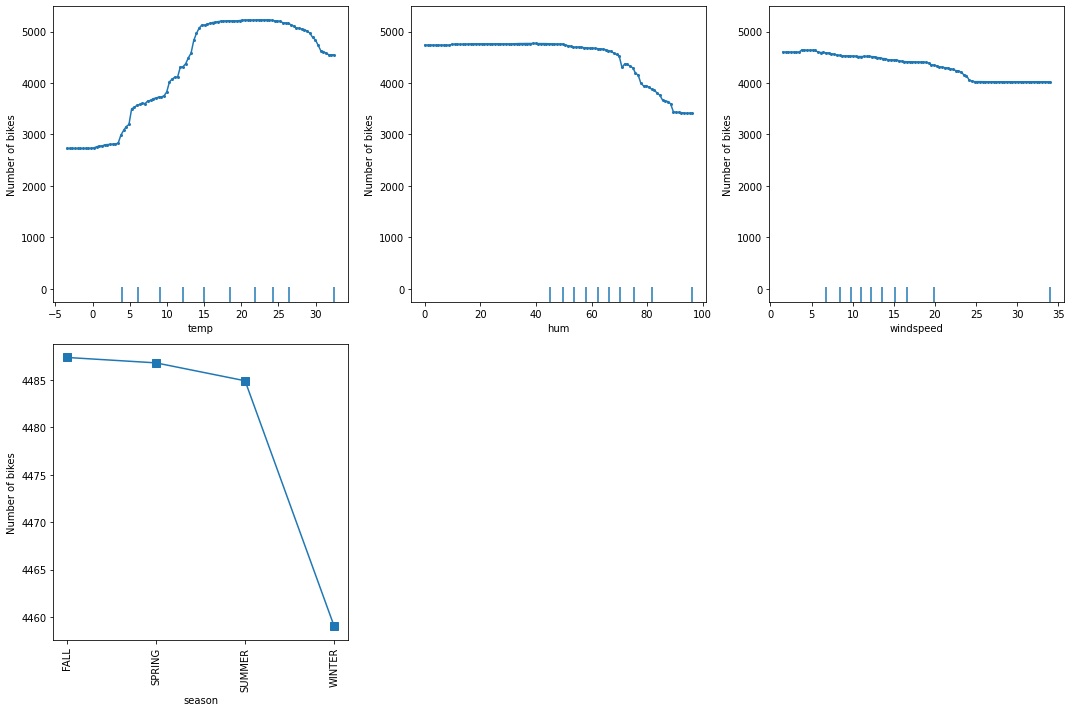

In [24]:
# compute explanations
exp = explainer.explain(X=X_train,
                        features_list=feature_list,
                        kind='average',
                        method='brute')

# plot partial dependece curves
plot_pd(exp=exp,
        n_cols=3,
        sharey='row',
        fig_kw={'figheight': 10, 'figwidth': 15});

We can observe that the average model prediction increases with the temperature till it reaches approximately $17^\circ C$. Then it flattens at a high number until the weather becomes too hot (i.e. approx. $27^\circ C$), after which it starts dropping again. 

The humidity larger than 60% seems to be a factor which inhibits the number of rentals since we can observe a downward trend from that point onward.

A similar analysis can be conducted for the wind speed. As the wind speed increases, less and less people are riding the bike. Interestingly, as also mentioned in [here](https://christophm.github.io/interpretable-ml-book/pdp.html), the number of bike rentals flattens between 25 and 35 km/h. By looking at the decile ticks, we can observe that there is not much data in that intervals. The model might not have learned to extrapolate correctly in that region, thus the predictions might not be meaningful.

Lastly, looking at the average prediction for each season, we can observe that all seasons show similar effect on the model predictions, with a slight decrease for the winter season.

###  Individual conditional expectation

Although the PD plots can give us some insight with respect to the average model response, it can also hide some heterogeneous effect. This is because the PD plots show the average marginal effects. To visualize the response of each individual data point and uncover heterogeneous effects we can use the ICE plots.

To compute the both the PD and the ICE, we simply set the parameter `kind='both'`. In this setting, the method parameter must be set to `method='brute'`, since the ICE cannot be computed for the `method='recursive'`. The rest of the calls remain the same.

Because the PD is the average of the ICE, the ICE plots can be heavily dispersed around the PD which can hide away the evolution of a data point as we change the feature value. Thus, it is recommended to center the plots at the beginning in 0 by subtracting the value corresponding to the initial feature value. 

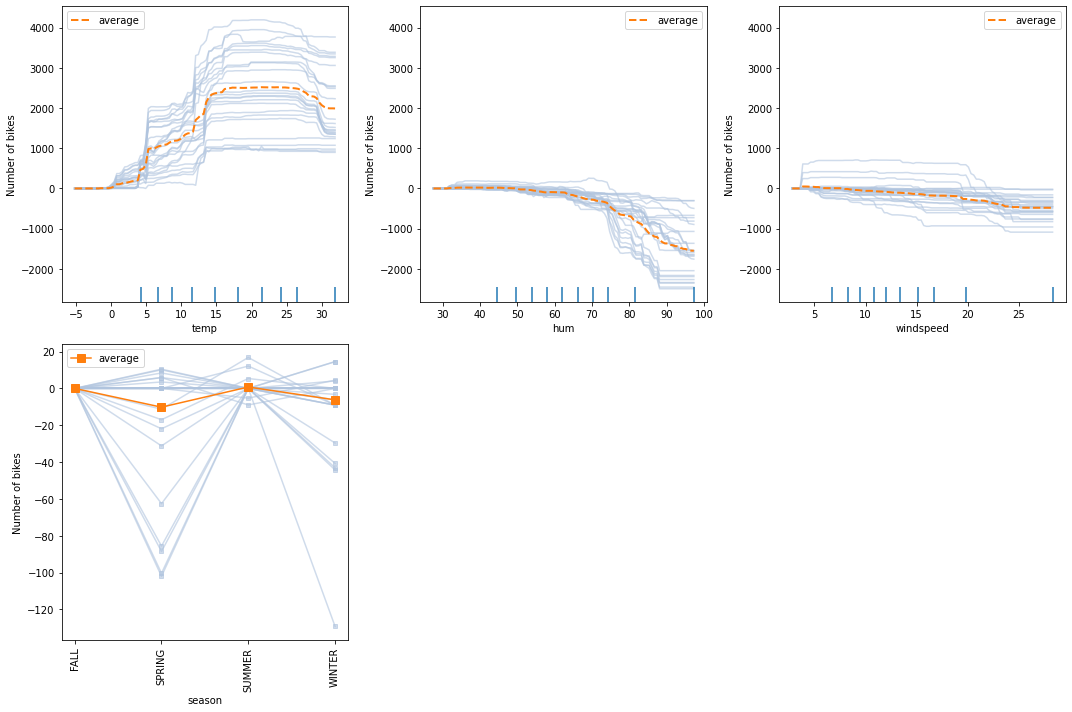

In [13]:
# compute explanations
exp = explainer.explain(X=X_train,
                        features_list=feature_list,
                        kind='both',
                        method='brute')

# plot the pd and ice
plot_pd(exp=exp,
        n_cols=3,
        n_ice=25,   # number of ICE curves to be displayed. Can be set to 'all' or provided a list of indices
        sharey='row',
        centered=True,  # center the plots for better visualization
        fig_kw={'figheight': 10, 'figwidth': 15});

For example, we can observe that there exist some particular scenarios in which the bike rental increases for winter relative to the other seasons. Such an effect was hidden from us in the PD plot.

### Partial dependence for two features

We will continue to provide some example and a brief analysis of two feature partial dependence plots, including combination of two numerical features, two categorical features, and one numerical & one categorical.

In [14]:
feature_list = [
    (feature_names.index('temp'), feature_names.index('windspeed')),
    (feature_names.index('mnth'), feature_names.index('weathersit')),
    (feature_names.index('season'), feature_names.index('temp'))    
]

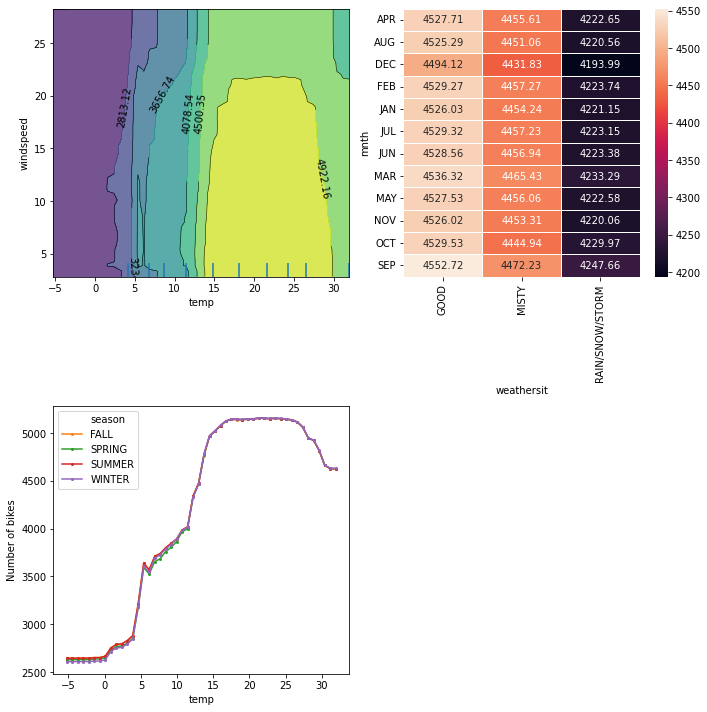

In [15]:
# compute explanations
exp = explainer.explain(X=X_train,
                        features_list=feature_list,
                        kind='average',
                        method='brute',
                        grid_resolution=50)

# plot partial dependece curves
plot_pd(exp=exp,
        n_cols=2,
        fig_kw={'figheight': 10, 'figwidth': 10});